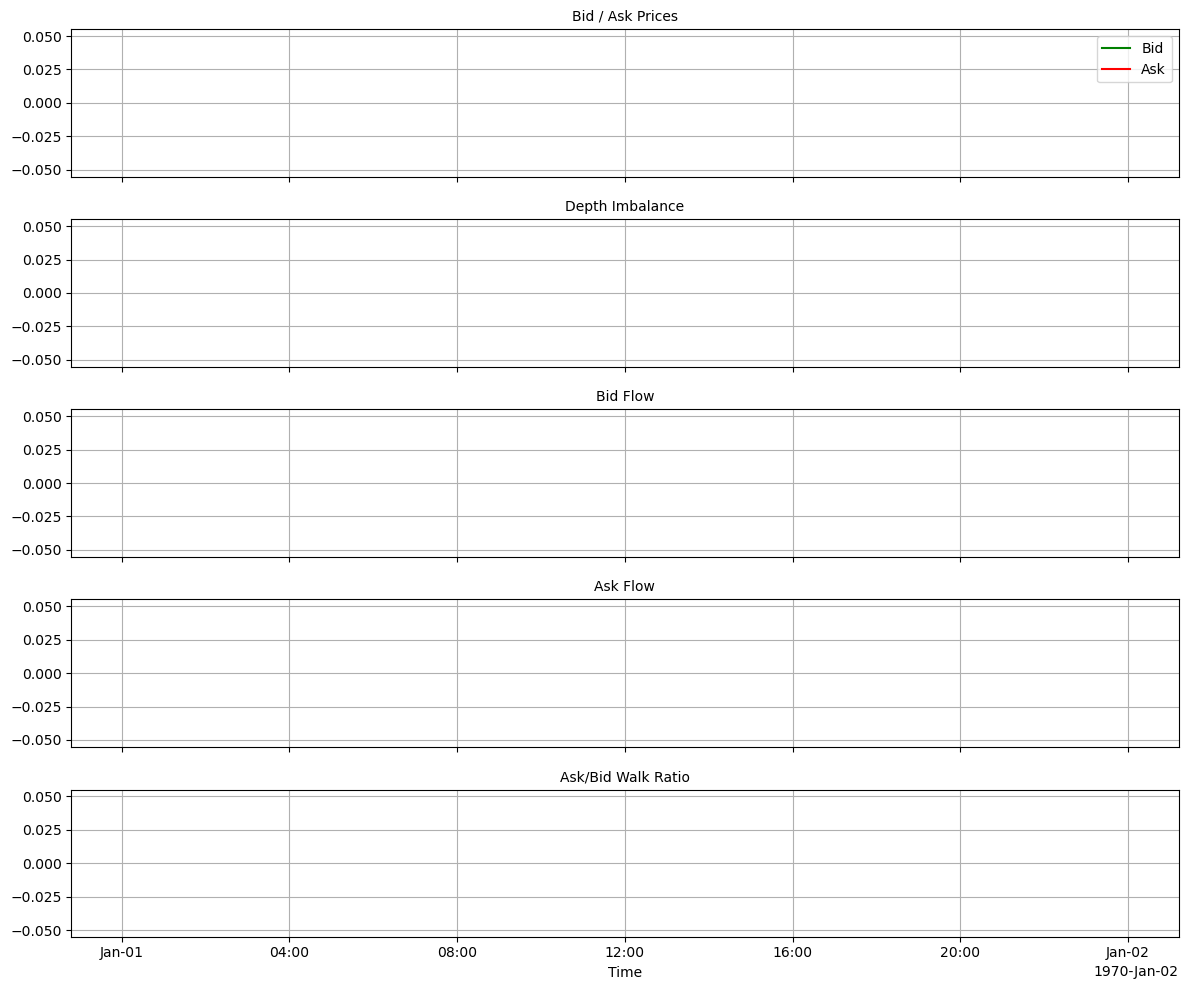

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import os

PLOT_REFRESH = 2000   # ms between updates
MAX_POINTS = 5000
PICKLE_FILE = "imbalance_live.pkl"

def get_imbalance_df():
    if os.path.exists(PICKLE_FILE):
        try:
            df = pd.read_pickle(PICKLE_FILE)
            df = df.tail(MAX_POINTS)
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
            return df
        except Exception as e:
            print(f"Pickle read error: {e}")
    return pd.DataFrame()

# --- Create figure and axes ---
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
titles = ["Bid / Ask Prices", "Depth Imbalance", "Bid Flow", "Ask Flow", "Ask/Bid Walk Ratio"]

locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)

for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=10)
    ax.grid(True)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

axes[-1].set_xlabel("Time")
plt.tight_layout()

# Initialize lines
line_bid, = axes[0].plot([], [], color="green", label="Bid")
line_ask, = axes[0].plot([], [], color="red", label="Ask")
axes[0].legend(loc="upper right")

line_depth, = axes[1].plot([], [], color="purple")
line_flow_bid, = axes[2].plot([], [], color="blue")
line_flow_ask, = axes[3].plot([], [], color="orange")
line_walk, = axes[4].plot([], [], color="black")

def animate(i):
    df = get_imbalance_df()
    if df.empty or "timestamp" not in df.columns:
        return line_bid, line_ask, line_depth, line_flow_bid, line_flow_ask, line_walk

    ts = df["timestamp"]

    # Update all lines efficiently
    line_bid.set_data(ts, df["bid_price"])
    line_ask.set_data(ts, df["ask_price"])
    line_depth.set_data(ts, df["depth_imbalance"])
    line_flow_bid.set_data(ts, df["flow_bid"])
    line_flow_ask.set_data(ts, df["flow_ask"])
    line_walk.set_data(ts, df["ask_bid_walk"])

    # Single relim/autoscale for all axes (more efficient)
    for ax in axes:
        ax.relim()
        ax.autoscale_view()

    return line_bid, line_ask, line_depth, line_flow_bid, line_flow_ask, line_walk

ani = animation.FuncAnimation(
    fig, animate, interval=PLOT_REFRESH, 
    repeat=True, cache_frame_data=False, blit=False
)
plt.show()
